# 馬と鹿を分類する
CIFAR10の分類器を作りそのSoftmaxスコアを調べたら、いくつかのクラスは識別困難になっていることが分かった。例えば馬と鹿の識別が困難であった。
この問題は本質的に電子と光子の識別問題の同じ困難だと考えられるので、まずCIFAR10の中から馬と鹿を区別する問題を考察する。

まずは、CIFAR10のデータセットから馬のデータと鹿のデータだけを持ってきて分類器を作成してみる。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import BatchSampler, SubsetRandomSampler, SequentialSampler,DataLoader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## データセットの準備
ここでは、馬と鹿のデータセットのみをロードすることを考える。

特定のデータセットを持ってくるには、サンプラーを用いる。
https://pytorch.org/docs/master/data.html#torch.utils.data.SequentialSampler
このリンクの`torch.utils.data.BatchSampler`に使い方が書かれている。

まず、`Sampler`は以下のようにリストを生成する。この時、サンプラーの種類によって様々なサンプルの仕方がある。例えば、`SubsetRandomSampler`だと、与えられたリストをランダムに混ぜて返す。

`SequentialSampler`は、正直ちゃんと理解していないが与えられたリストの次元と同じ次元で、0,1,2,...というリストを返す。つまり引数にどんなリストを渡すかはあまり関係なさそう。

一方で、`BatchSampler`はリストを与えると、そのリストを指定したバッチサイズでミニバッチごとに分けて返してくれる。

つまり、CIFAR10から特定のラベルのデータを読み込むという今回の目的においては、基本的に以下のようにすればよい。
* 特定のラベルを持つ画像のインデックスのリストを取得する
* このインデックスのリストをBatchSamplerを用いてミニバッチに分ける
この際、データのシャッフルをどうするかなどに応じてオプションを変えていけば良い。

In [17]:
print(list(SubsetRandomSampler([1,3,5,7,9], generator=None)))
print(list(SubsetRandomSampler(range(5), generator=None)))

print(list(SequentialSampler([1,3,5,7,9])))
print(list(SequentialSampler(range(5))))

[1, 5, 3, 9, 7]
[3, 1, 4, 2, 0]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


In [10]:
list(SubsetRandomSampler(range(5), generator=None))

[1, 2, 3, 4, 0]

In [50]:
list(BatchSampler(SubsetRandomSampler(range(10), generator=None), batch_size=4, drop_last=True))

[[4, 3, 8, 2], [5, 7, 9, 1]]

In [51]:
list(BatchSampler(torch.utils.data.SequentialSampler(range(10)), batch_size=4, drop_last=True))

[[0, 1, 2, 3], [4, 5, 6, 7]]

よって、やるべきことは
サンプラーに渡すリストに、用いるクラスの画像のインデックスをすべて格納して渡せばよい。

まずは以下のようにいろいろ実験してみる。

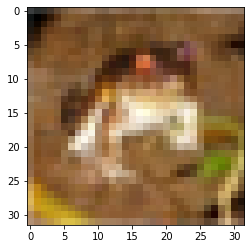

tensor([6])


In [52]:
loader = DataLoader(trainset)
myiter = iter(loader)

img, lbl = myiter.next()

# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(lbl)

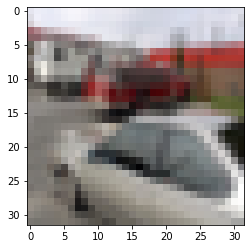

tensor([1])


In [53]:
loader = DataLoader(trainset)
#myiter = iter(loader)

for i, data in enumerate(loader):
    img, lbl = data

# show images
imshow(torchvision.utils.make_grid(img))
# print labels
print(lbl)

In [54]:
lbl.numpy().item() in target_class

False

In [55]:
loader = DataLoader(trainset)
target_list = []

for i, data in enumerate(loader):
    _, label = data
    if(label.numpy().item() in target_class):
        target_list.append(i)

# print labels
print(len(target_list))

10000


In [56]:
len(trainset)

50000

教師データが50000枚ある。つまり各クラスに対しては5000枚ずつあり、今二つのクラスを持ってきているので全部で10000枚で、矛盾はない。

欲しかったリストは、`target_list`に格納された。

In [59]:
loader = DataLoader(testset)
target_list = []

for i, data in enumerate(loader):
    _, label = data
    if(label.numpy().item() in target_class):
        target_list.append(i)

# print labels
print(len(target_list))

2000


### 教師データの準備

In [57]:
target_class = [4,7]

In [58]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

tmp_loader = DataLoader(trainset)
train_target = []

for i, data in enumerate(tmp_loader):
    _, label = data
    if(label.numpy().item() in target_class):
        train_target.append(i)

trainloader = DataLoader(trainset,num_workers=0, batch_sampler = BatchSampler(SubsetRandomSampler(train_target, generator=None), batch_size=4, drop_last=True))

Files already downloaded and verified


### テストデータの準備

In [70]:
#print(test_target)
#print(train_target)
#list(BatchSampler(SubsetRandomSampler(train_target, generator=None), batch_size=4, drop_last=True))
#list(BatchSampler(test_target, batch_size=4, drop_last=True))

In [73]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [71]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

tmp_loader = DataLoader(testset)
test_target = []

for i, data in enumerate(tmp_loader):
    _, label = data
    if(label.numpy().item() in target_class):
        test_target.append(i)
        
testloader = DataLoader(testset, num_workers=0, batch_sampler = BatchSampler(test_target, batch_size=4, drop_last=True))

Files already downloaded and verified


In [72]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

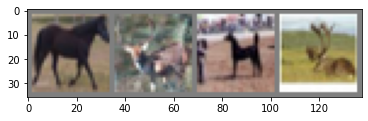

horse  deer horse  deer


In [74]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

以上のようにして、馬と鹿だけからなるデータセットを用意することができた。

テストデータに対しても以下のように確かに得ることができた。

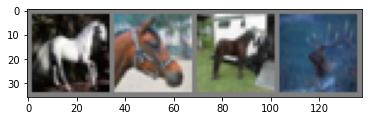

horse horse horse  deer


In [75]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

今回は10個のクラスのうち2つを持ってくるのでクラスも2つのものに成型しておく。

In [76]:
classes = (classes[4],classes[7])

## ネットワークの定義
今回、2つの画像の分類を行うので、ネットワークからのアウトプットは2つにする。

In [77]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)# 今回は出力が2つ

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


## Optimizerの定義

In [78]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## トレーニング 
今回、上述の理由でアプトプットは2つである。その一方で画像のラベルは依然として0～9の範囲で出力される。このラベルを0，1にマップする関数を以下で用意する。

In [79]:
#[4,7]を[0,1]に変換する関数
def relabel(tensor):
    nparray = tensor.numpy()
    newarray = np.array([])
    for elem in nparray:
        if(elem == 4) :
            newarray = np.append(newarray,0)
        else:
            newarray = np.append(newarray,1)
    return torch.Tensor(newarray).long()#crossentropyの引数はLong型なのでキャストしておく。

In [80]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):#第2引数はインデックスの初期値
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(labels)
#         print(relabel(labels))
#         print(outputs)
        loss = criterion(outputs, relabel(labels))#ネットワークから出力された10個の値と、このループでのミニバッチのラベルを比較する。
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
#         if i%200 == 199:
#             print(loss,running_loss)
        
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.688
[1,  1000] loss: 0.664
[1,  1500] loss: 0.603
[1,  2000] loss: 0.545
[1,  2500] loss: 0.503
[2,   500] loss: 0.484
[2,  1000] loss: 0.445
[2,  1500] loss: 0.444
[2,  2000] loss: 0.454
[2,  2500] loss: 0.436
[3,   500] loss: 0.408
[3,  1000] loss: 0.416
[3,  1500] loss: 0.413
[3,  2000] loss: 0.388
[3,  2500] loss: 0.431
[4,   500] loss: 0.372
[4,  1000] loss: 0.378
[4,  1500] loss: 0.380
[4,  2000] loss: 0.365
[4,  2500] loss: 0.369
[5,   500] loss: 0.338
[5,  1000] loss: 0.360
[5,  1500] loss: 0.334
[5,  2000] loss: 0.352
[5,  2500] loss: 0.332
[6,   500] loss: 0.313
[6,  1000] loss: 0.313
[6,  1500] loss: 0.330
[6,  2000] loss: 0.314
[6,  2500] loss: 0.323
[7,   500] loss: 0.276
[7,  1000] loss: 0.308
[7,  1500] loss: 0.274
[7,  2000] loss: 0.295
[7,  2500] loss: 0.319
[8,   500] loss: 0.267
[8,  1000] loss: 0.269
[8,  1500] loss: 0.273
[8,  2000] loss: 0.277
[8,  2500] loss: 0.267
[9,   500] loss: 0.245
[9,  1000] loss: 0.225
[9,  1500] loss: 0.248
[9,  2000] 

## データの保存

In [81]:
PATH = './horsedeer_net.pth'
torch.save(net.state_dict(), PATH)

## データの可視化

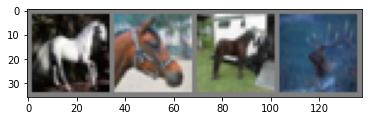

In [82]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))


次に、学習済みのネットワークから判定を行う。

In [83]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [84]:
outputs = net(images)

In [85]:
print(outputs.size())
print(outputs)

torch.Size([4, 2])
tensor([[-5.9202,  5.3552],
        [-0.3945,  0.5284],
        [-1.1804,  1.3230],
        [ 2.6065, -2.2399]], grad_fn=<AddmmBackward>)


In [86]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  horse horse horse  deer


In [89]:
net = Net()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == relabel(labels)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


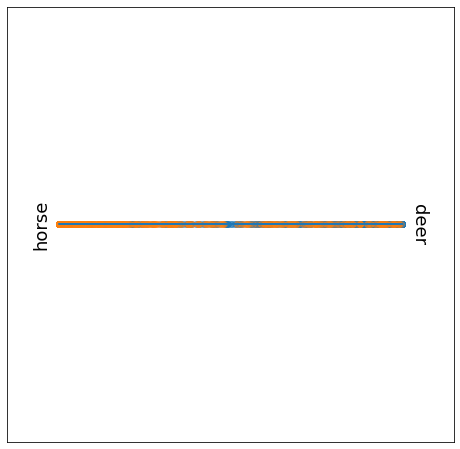

In [92]:
from scipy.special import softmax

num_class = len(target_class)

unit_x = np.array([ np.cos(2 * np.pi * i / num_class) for i in range(num_class)])
unit_y = np.array([ np.sin(2 * np.pi * i / num_class) for i in range(num_class)])

net = Net()
net.load_state_dict(torch.load(PATH))

prediction = []
sm_list = []
label_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        label_list.append(relabel(labels).numpy())
        
        sm = softmax(outputs.numpy(),axis=1)#axis = 1 にしておくと確率を１に規格化する。
        sm_list.append(sm)
        
    sm_array = np.concatenate(sm_list)
    l_array = np.concatenate(label_list)

list_x = []
list_y = []
for sm in sm_array:
    list_x.append(np.dot(unit_x , sm))
    list_y.append(np.dot(unit_y , sm))
        
fig,axis=plt.subplots(figsize=(8,8),facecolor='w')
plt.plot(np.append(unit_x,unit_x[0]),np.append(unit_y,unit_y[0]))
axis.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)

for label in range(num_class):
    idx = np.where(l_array == label)
    sm_class = sm_array[idx]
    
    list_x = []
    list_y = []
    
    for sm in sm_class:
        list_x.append(np.dot(unit_x , sm))
        list_y.append(np.dot(unit_y , sm))
    
    plt.scatter(list_x,list_y,alpha=0.3)
    
for d,name in enumerate(classes):
        plt.text(unit_x[d]*1.1, unit_y[d]*1.1,str(name),fontsize=18,ha='center',va='center',rotation= -90 + 360/num_class*d)#-90 + 2 * np.pi/num_class*d/np.pi*180

plt.show()